In [21]:
import torch
import torchvision 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [22]:
dataset = torchvision.datasets.EMNIST(root="../data", download=True, split="letters")
dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ../data
    Split: Train

In [23]:
X = dataset.data
Y = dataset.targets

In [24]:
len(dataset) * 0.8

99840.0

In [25]:
train_size = 99840
Xtrain = X[:train_size] /255
Ytrain = Y[:train_size]
Ytrain = Y[:train_size].unsqueeze(1)

Xtest = X[train_size:] /255
Ytest = Y[train_size:]
Ytest = Y[train_size:].unsqueeze(1)

In [26]:
ninput = 784
nhidden = 256
nhidden2 = 256
batch_size =64
nclasses = len(dataset.classes)

In [27]:
W1 = torch.randn(ninput, nhidden, requires_grad=True) * torch.sqrt(torch.tensor(2.0) / (ninput + nhidden))
b1 = torch.randn(1, nhidden, requires_grad=True)
W2 = torch.randn(nhidden, nhidden2, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b2 = torch.randn(1, nhidden2, requires_grad=True)
W3 = torch.randn(nhidden2, nclasses, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b3 = torch.zeros(1, nclasses, requires_grad=True)

gamma1 = torch.ones((100,))
gamma2 = torch.ones((50,))
beta1 = torch.zeros((100,))
beta2 = torch.zeros((50,))

In [28]:
num_batches = len(Xtrain) // batch_size

In [29]:
alpha = 0.1
losses = []
val_losses = []

for epoch in range(10):
    epoch_loss = 0.0
    for i in range(num_batches):
        # Create batch
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = Xtrain[start_idx:end_idx]
        Y_batch = Ytrain[start_idx:end_idx]

        # Forward pass
        Z1 = X_batch.view(-1, ninput) @ W1 + b1
        A1 = torch.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        zmax = Z3.max(dim=1, keepdim=True).values
        znorm = Z3 - zmax
        zexp = znorm.exp()
        zexp_sum = zexp.sum(dim=1, keepdim=True)
        zexp_sum_inv = zexp_sum ** (-1)
        probs = zexp * zexp_sum_inv
        log_probs = probs.log()
        L = -log_probs[torch.arange(len(Y_batch)), Y_batch.squeeze()].mean()
        epoch_loss += L.item()

        # Backward pass
        dL_dL = torch.ones_like(L)
        dL_dlogprobs = torch.zeros_like(log_probs)
        dL_dlogprobs[torch.arange(len(Y_batch)), Y_batch.squeeze()] = -dL_dL / len(Y_batch)
        dL_dprobs = dL_dlogprobs * 1 / probs
        dL_dzexp = dL_dprobs * zexp_sum_inv
        dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
        dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
        dL_dzexp += dL_dzexp_sum
        dL_dznorm = dL_dzexp * zexp.clone()
        dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
        dL_dZ = dL_dznorm
        dL_dZ += torch.nn.functional.one_hot(Z3.max(dim=1).indices, nclasses) * dL_dzmax
        dL_dW3 = A2.T @ dL_dZ
        dL_db3 = dL_dZ.sum(0, keepdim=True)
        dL_dA2 = dL_dZ @ W3.T
        dL_dZ2 = dL_dA2 * (1 - A2**2)
        dL_dW2 = A1.T @ dL_dZ2
        dL_db2 = dL_dZ2.sum(0, keepdim=True)
        dL_dA1 = dL_dZ2 @ W2.T
        dL_dZ1 = dL_dA1 * (1 - A1**2)
        dL_dW1 = X_batch.view(-1, ninput).T @ dL_dZ1
        dL_db1 = dL_dZ1.sum(0, keepdim=True)

        with torch.no_grad():
            W1 -= alpha * dL_dW1
            b1 -= alpha * dL_db1
            W2 -= alpha * dL_dW2
            b2 -= alpha * dL_db2
            W3 -= alpha * dL_dW3
            b3 -= alpha * dL_db3

    # Calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for j in range(len(Xtest) // batch_size):
            start_idx = j * batch_size
            end_idx = (j + 1) * batch_size
            X_val = Xtest[start_idx:end_idx]
            Y_val = Ytest[start_idx:end_idx]

            Z1_val = X_val.view(-1, ninput) @ W1 + b1
            A1_val = torch.tanh(Z1_val)
            Z2_val = A1_val @ W2 + b2
            A2_val = torch.tanh(Z2_val)
            Z3_val = A2_val @ W3 + b3
            val_loss += -torch.nn.functional.log_softmax(Z3_val, dim=1)[torch.arange(len(Y_val)), Y_val.squeeze()].mean().item()
    val_loss /= (len(Xtest) // batch_size)

    losses.append(epoch_loss / num_batches)
    val_losses.append(val_loss)

    print(f"Epoch {epoch}, Loss: {losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 0, Loss: 1.0294515928778893, Validation Loss: 0.6552780931576704
Epoch 1, Loss: 0.5327477173640942, Validation Loss: 0.46634813333169006
Epoch 2, Loss: 0.4057452173664784, Validation Loss: 0.3961051311630469
Epoch 3, Loss: 0.3415578676387668, Validation Loss: 0.3611143586727289
Epoch 4, Loss: 0.2999201793844501, Validation Loss: 0.3417207603462232
Epoch 5, Loss: 0.2692303562632356, Validation Loss: 0.3302642859518528
Epoch 6, Loss: 0.24488787944309223, Validation Loss: 0.3228802860356294
Epoch 7, Loss: 0.22466634484246756, Validation Loss: 0.3179855713668542
Epoch 8, Loss: 0.20730070137203885, Validation Loss: 0.3149546844836993
Epoch 9, Loss: 0.19201221795848164, Validation Loss: 0.313447717940196


In [30]:
# def compare_grad(s, dX, X):
#     exact = torch.all(dX == X.grad).item()
#     close = torch.allclose(dX, X.grad)
#     maxdiff = (dX - X.grad).abs().max().item()
#     print(f"{s:15s} | exact: {str(exact):5s} | approximate:{str(close):5s} | maxdiff: {maxdiff}")

In [31]:
# compare_grad('logprobs', dL_dlogprobs, log_probs)
# compare_grad('probs', dL_dprobs, probs)
# compare_grad('zexp', dL_dzexp, zexp)
# compare_grad('zexp_sum_inv', dL_dzexp_sum_inv, zexp_sum_inv)
# compare_grad('zexp_sum', dL_dzexp_sum, zexp_sum)
# compare_grad('znorm', dL_dznorm, znorm)
# compare_grad('zmax', dL_dzmax, zmax)
# # compare_grad('Z3', dL_dZ3, Z3)
# # compare_grad('W3', dL_dW3, W3)
# # compare_grad('b3', dL_db3, b3)
# compare_grad('Z2', dL_dZ2, Z2)
# compare_grad('W2', dL_dW2, W2)
# compare_grad('b2', dL_db2, b2)
# compare_grad('Z1', dL_dZ1, Z1)
# compare_grad('W1', dL_dW1, W1)
# compare_grad('b1', dL_db1, b1)

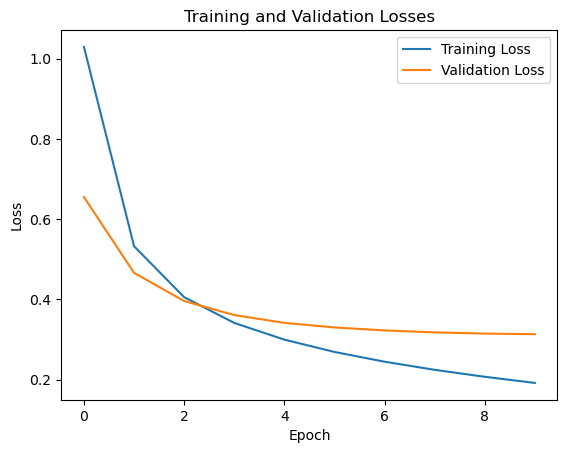

In [32]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [33]:
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(Xtest)):
        Z1 = Xtest[i].view(1, -1) @ W1 + b1
        A1 = torch.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        predicted_class = torch.argmax(Z3, dim=1)

        if predicted_class == Ytest[i]:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.9007211538461538
